# 多层前馈网络 （多层感知器）

## 使用多层感知器 拟合sin函数

In [1]:
import os
import numpy as np
from nnc import dataset as Data
from nnc.plot_tool import *

In [2]:
# 定义 激活函数
def linear(x,w,t):
    # 线性运算
    return np.dot(x,w)-t

def logistic(x):
    # Logistic 激活函数
    return 1.0 /(1.0 + np.exp(-x))
def logistic_grad(x):
    f = logistic(x)
    return np.multiply(f, (1.0 - f))

# 定义误差函数 
# 二次损失函数  
def quadratic(y,y_pred):
    return np.sum((y-y_pred)**2)/2

def quadratic_grad(y,y_pred):
    return -(y-y_pred)

# 均方误差函数
def mse(y,y_pred):
    return np.mean((y-y_pred)**2)

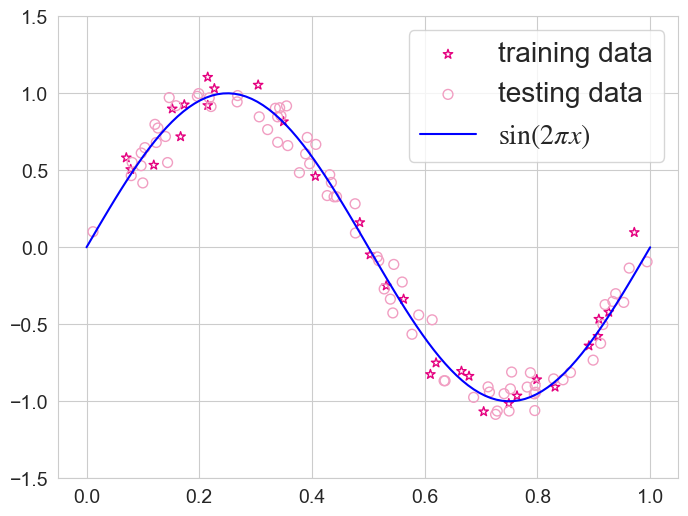

(30,)
(30,)


In [3]:
# 生成 sin 数据
# 由sin()函数生成数据
Data.seed_random(2024)    
# (1) 数据集构建
# 随机采集1000个样本，并进行可视化。
train_num = 30               # 训练样本数目
test_num = 80                # 测试样本数目
noise =  0.1 #    0.0 #      # 数据中加入方差为noise的Gaussian白噪声
# 生成数据
sin = Data.sin_data()
sin.gen_data(train_num=train_num,test_num=test_num,noise=noise)
# 训练数据集
train_dataset = (sin.train_data[0].numpy(),sin.train_data[1].numpy())
# 测试数据集
test_dataset = (sin.test_data[0].numpy(),sin.test_data[1].numpy())

# 绘制数据图像
fig_path = os.path.normpath('image/regression/sin_mlp/sin{}/fig/noise{}'.format(train_num,noise))
sin.draw_data(fig_path,fig_name=f'sin_train{train_num}_test{test_num}_n{noise}.pdf',
              train_data=train_dataset,test_data=test_dataset)


print(train_dataset[0].shape)
print(train_dataset[1].shape)

In [4]:
# 模型预测
def predict(X,param):  
    X = X.reshape(len(X),param['input_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = logistic(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = z2                                 # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）
    return y_pred

# 模型评价
def evaluate(dataset,param):        
    X, y = dataset
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = logistic(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = z2                                 # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）
    # 均方误差
    #loss = np.sum((y-y_pred)**2)
    loss = mse(y,y_pred)
    return loss

# 样本训练 
# 2层前向神经网络结构，1-h-1
def mlp2_train(train_set,test_set,param,lr,epochs,eps,log_epochs=10):
    
    # 存放算法训练过程中的训练样本和测试样本误差
    loss = {}
    loss['train'] = []
    loss['test'] = []
    
    # train_set 训练数据(X,y)
    X,y = train_set
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    N = X.shape[0]  # 样本数目
    
    # 使用梯度下降法
    for epoch in range(epochs):  # 训练轮数
        y_pred = np.zeros((N,1))    # 存放每个样本的实际输出
        for n in range(N):
            # 取出第n个样本输入网络进行权值更新
            # (1) 计算各层输出
            z1 = linear(X[n],param['w1'],param['t1'])      # 隐层净输入向量
            y1 = logistic(z1)                              # 隐层的输出向量
            z2 = linear(y1,param['w2'],param['t2'])        # 输出层净输入向量
            y_pred[n] = z2                                 # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）            
            # (2) 计算误差（损失）
            e = quadratic(y[n],y_pred[n])     # 二次损失函数 
            # 二次损失函数 关于输出y_pred的导数
            e_grad = quadratic_grad(y[n],y_pred[n]).reshape(1,param['output_size'])           
            # (3) 计算误差项(误差逐层反传)
            # 输出层激活函数（恒等变换）f(z) = z = y_pred, 输出y_pred关于净输入z2的导数等于1
            # e2 = (y[n]-y_pred[n])   
            e2 = - e_grad
            e1 = np.multiply(logistic_grad(z1),np.matmul(e2,param['w2'].T))
            # (3) 权值和阈值修正
            param['w2'] = param['w2'] + lr* np.matmul(y1.T, e2)     # 权值修正
            param['t2'] = param['t2'] - lr* e2                      # 阈值修正
            param['w1'] = param['w1'] + lr* np.matmul(X[n].T, e1)   # 权值修正
            param['t1'] = param['t1'] - lr* e1                      # 阈值修正
        # 一轮训练结束，计算训练误差
        #train_loss = np.sum((y-y_pred)**2)
        train_loss = mse(y,y_pred)
        loss['train'].append(train_loss)
        
        # 对测试集进行评价        
        if test_set is not None:
            test_loss = evaluate(test_set,param)
            loss['test'].append(test_loss)
        
        # 打印过程
        if log_epochs and epoch % log_epochs == 0:
            if test_set is None:
                print(f"[Train] epoch: {epoch}/{epochs}, train_loss: {train_loss}")
            else:
                print(f"[Train/Test] epoch: {epoch}/{epochs}, train_loss: {train_loss}, test_loss:{test_loss}")
        
        # 判断算法是否停止(评价模型)
        if train_loss < eps or epoch == epochs-1:  
            print('\n 训练结束: ')
            if train_loss < eps:
                print(f' - 算法迭代次数: {epoch+1}')
            else:
                print(f' - 算法迭代次数: {epoch}')
            return loss,param

    

开始训练 ......
[Train/Test] epoch: 0/5000, train_loss: 0.6630071207268459, test_loss:0.44598921049352863
[Train/Test] epoch: 100/5000, train_loss: 0.18323667454170464, test_loss:0.19978442208972716
[Train/Test] epoch: 200/5000, train_loss: 0.1707603007341438, test_loss:0.1808006954752873
[Train/Test] epoch: 300/5000, train_loss: 0.15298265469598687, test_loss:0.1552616750807066
[Train/Test] epoch: 400/5000, train_loss: 0.13231803470385647, test_loss:0.12912212805825812
[Train/Test] epoch: 500/5000, train_loss: 0.10526047137649969, test_loss:0.09854279767263951
[Train/Test] epoch: 600/5000, train_loss: 0.0668515392063142, test_loss:0.0566577530718696
[Train/Test] epoch: 700/5000, train_loss: 0.03595373495824945, test_loss:0.02607740698409705
[Train/Test] epoch: 800/5000, train_loss: 0.022813385279676194, test_loss:0.016645882230229624
[Train/Test] epoch: 900/5000, train_loss: 0.0191803362923641, test_loss:0.015886875514193204
[Train/Test] epoch: 1000/5000, train_loss: 0.018144635758253348,

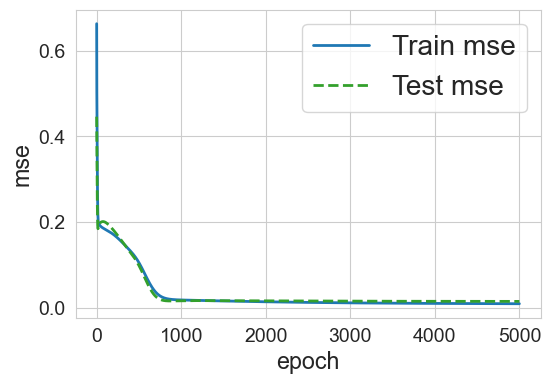

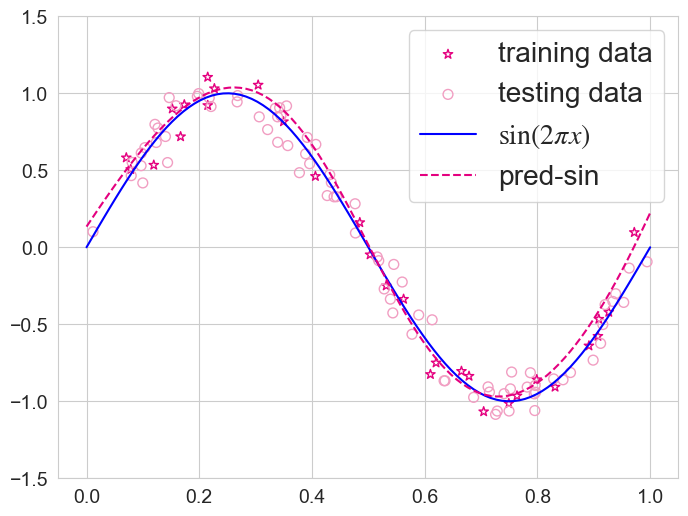

In [5]:
# mlp  1-3-1
param = {}        # 网络参数
input_size = 1    # 输入层节点数目
hidden_size = 3   # 隐层神经元数目
output_size = 1   # 输出层神经元数目
param['input_size'] = input_size
param['hidden_size'] = hidden_size
param['output_size'] = output_size

# 设置初始权值和阈值
param['w1'] = np.random.randn(input_size,hidden_size)   # 隐层权值        # 默认"标准正态分布初始化"  
param['t1'] = np.zeros((1,hidden_size))                 # 隐层阈值        # 默认 0
param['w2'] = np.random.randn(hidden_size,output_size)  # 输出层权值
param['t2'] = np.zeros((1,output_size))                 # 输出层阈值

# 设置算法参数
lr = 0.1                                     # 学习率
epochs = 5000                                # 最大训练轮数
eps = 1e-3                                     # 训练停止精度要求
log_epochs = 100

print("====================================================================")
print("开始训练 ......")
# 训练模型
loss,param = mlp2_train(train_dataset,test_dataset,param,lr,epochs,eps,log_epochs=log_epochs)

fig_path = os.path.normpath(os.path.join(fig_path,f"h{hidden_size}_o{output_size}_lr{lr}"))
# (3) 可视化 --- 观察训练集与验证集的指标变化情况  
# (3.1) 绘制训练\测试 损失变化曲线
fig_name = 'train-test-{}.pdf' 
param_name = 'epoch'    
metric_name =  'mse' 
train_results = (loss['train'],[])
test_results = (loss['test'],[])
draw_scores(fig_path,fig_name.format(metric_name),train_scores=train_results,
                      test_scores=test_results,metric=metric_name,param_name=param_name)

# (3.2) 绘制拟合曲线
X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
y_underlying_pred = predict(X_underlying.reshape([-1,1]),param)
sin.draw_data(fig_path,fig_name=f'sin_mpl_h{hidden_size}.pdf',
              train_data=train_dataset,test_data=test_dataset,
              pred_underlying_data=(X_underlying,y_underlying_pred),label='pred-sin')


print("====================================================================")

In [6]:
# 3层前向神经网络结构，1-h-h-1
def mlp3_train(train_set,test_set,param,lr,epochs,eps,log_epochs=10):
    
    # 存放算法训练过程中的训练样本和测试样本误差
    loss = {}
    loss['train'] = []
    loss['test'] = []
    
    # train_set 训练数据(X,y)
    X,y = train_set
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    N = X.shape[0]  # 样本数目
    
    # 使用梯度下降法
    for epoch in range(epochs):  # 训练轮数
        y_pred = np.zeros((N,1))    # 存放每个样本的实际输出
        for n in range(N):
            # 取出第n个样本输入网络进行权值更新
            # (1) 计算各层输出
            z1 = linear(X[n],param['w1'],param['t1'])      # 隐层净输入向量
            y1 = logistic(z1)                              # 隐层的输出向量
            z2 = linear(y1,param['w2'],param['t2'])        # 输出层净输入向量
            y_pred[n] = z2                                 # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）            
            # (2) 计算误差（损失）
            e = quadratic(y[n],y_pred[n])     # 二次损失函数 
            # 二次损失函数 关于输出y_pred的导数
            e_grad = quadratic_grad(y[n],y_pred[n]).reshape(1,param['output_size'])           
            # (3) 计算误差项(误差逐层反传)
            # 输出层激活函数（恒等变换）f(z) = z = y_pred, 输出y_pred关于净输入z2的导数等于1
            # e2 = (y[n]-y_pred[n])   
            e2 = - e_grad
            e1 = np.multiply(logistic_grad(z1),np.matmul(e2,param['w2'].T))
            # (3) 权值和阈值修正
            param['w2'] = param['w2'] + lr* np.matmul(y1.T, e2)     # 权值修正
            param['t2'] = param['t2'] - lr* e2                      # 阈值修正
            param['w1'] = param['w1'] + lr* np.matmul(X[n].T, e1)   # 权值修正
            param['t1'] = param['t1'] - lr* e1                      # 阈值修正
        # 一轮训练结束，计算训练误差
        #train_loss = np.sum((y-y_pred)**2)
        train_loss = mse(y,y_pred)
        loss['train'].append(train_loss)
        
        # 对测试集进行评价        
        if test_set is not None:
            test_loss = evaluate(test_set,param)
            loss['test'].append(test_loss)
        
        # 打印过程
        if log_epochs and epoch % log_epochs == 0:
            if test_set is None:
                print(f"[Train] epoch: {epoch}/{epochs}, train_loss: {train_loss}")
            else:
                print(f"[Train/Test] epoch: {epoch}/{epochs}, train_loss: {train_loss}, test_loss:{test_loss}")
        
        # 判断算法是否停止(评价模型)
        if train_loss < eps or epoch == epochs-1:  
            print('\n 训练结束: ')
            if train_loss < eps:
                print(f' - 算法迭代次数: {epoch+1}')
            else:
                print(f' - 算法迭代次数: {epoch}')
            return loss,param